# Lista 2 - Regresja Poissona

## Streszczenie

W niniejszym raporocie zajmiemy się *analizą danych przy pomocy modelu regresji Poissona*. <br>
W tym celu posłużymy się zbiorem danych znajdującym się w pliku *sklep.csv* <br>

Zbiór ten zawiera dane klientów pewnego sklepu **dotyczące 3 miesięcy**, w tym:

- **no.kilents** - liczba obsłużonych klientów w danej godzinie - $Y$  zmienna objaśniana
- **day** - dzień tygodnia (wart.: poniedziałek, wtorek,...,niedziela)
- **hour** - godzina (wart.: 8,9,...,23)
- **events** - czy miało miejsce jakieś wydarzenie sportowe - zmienna binarna (wart.: 0 - nie, 1 -tak)

Analizie poddamy kilka modeli - w tym model z interakcją oraz model z dodatkowymi zmiennymi.<br> W ten sposób określimy, które zmienne mają wpływ na liczbę obsłużonych klientów. <br>
W ostatnim etapie określimy optymalną liczbę pracowników sklepu w oparciu o poczynione wnioski oraz skonstruujemy dla nich grafik. <br>



## Wstęp

**Regresja Poissona** -  jest modelem statystycznym służącym do analizy liczby zdarzeń występujących w określonym przedziale czasu, przestrzeni lub innej jednostce miary. <br>
Jest stosowana, gdy zmienna zależna przyjmuje wartości całkowite nieujemne i opisuje częstość występowania danego zjawiska. <br>

Główne zastosowania regresji Poissona obejmują:

- Medycynę (np. liczba hospitalizacji pacjentów w danym okresie),

- Transport (np. liczba wypadków na skrzyżowaniach),

- Kryminologię (np. liczba przestępstw w danej dzielnicy),

- Ekonomię (np. liczba klientów odwiedzających sklep w ciągu dnia). - jak w analizowanym przez nas przykładzie

Teoretyczny model jest postaci:
$$
log(\lambda)= X\beta = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n 
$$

gdzie $\lambda$ to wartość oczekiwana liczby zdarzeń, a $X_1, X_2, \dots, X_n$ to zmienne objaśniające.<br>

Regresja Poissona pozwala na modelowanie zależności między zmiennymi i przewidywanie liczby zdarzeń, co czyni ją cennym narzędziem w analizie danych o charakterze liczbowym.<br>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit, logit
from scipy.stats import norm, cauchy, chi2
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc
import statsmodels.formula.api as smf

import warnings

In [2]:
dane = pd.read_csv("sklep",index_col=[0])

dane.columns = ["hour","day","events","no.klients"]

kolejnosc_dni = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

dane["day"] = pd.Categorical(dane["day"], categories=kolejnosc_dni, ordered=True)


# Wstępna analiza danych

>## Boxploty

Analize rozpoczniemy od narysowania wykresów pudełkowych przedstawiających zależność zmiennej y od każdego z predyktorów osobno. <br>
To znaczy sprawdzimy wstępnie w jaki sposób liczba klientów zmienia się w zależności od dnia tygodnia, konkretnej godziny oraz występowania wydarzeń sportowych.<br>

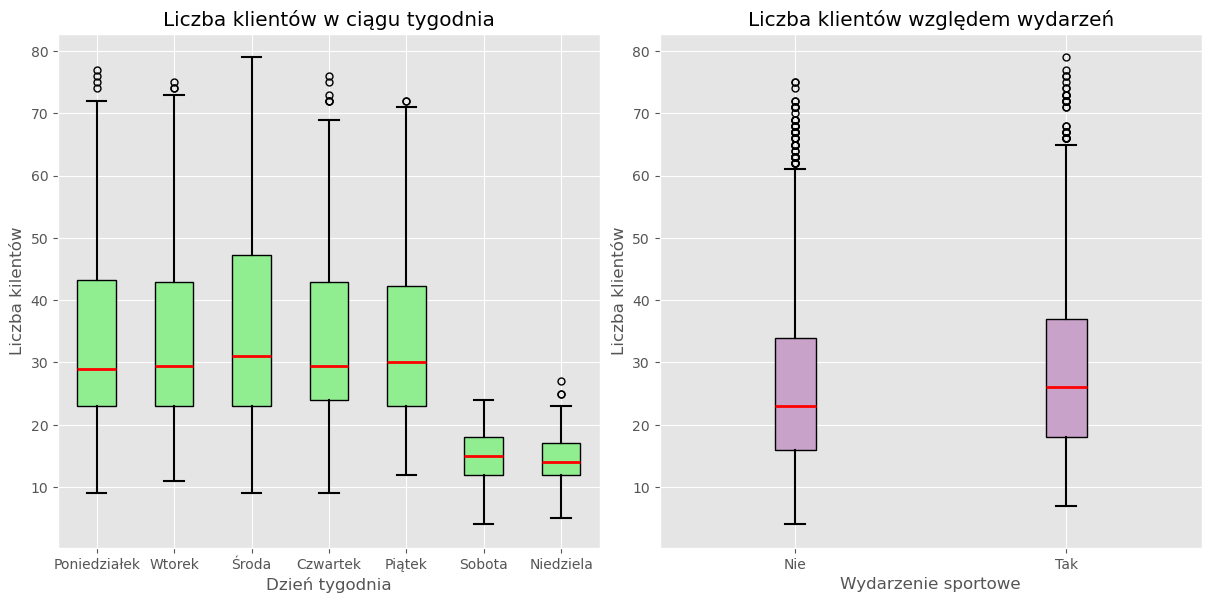

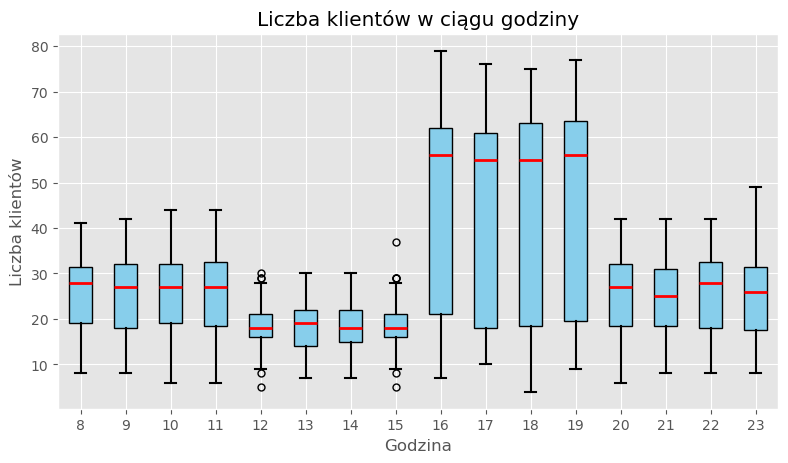

In [3]:

plt.style.use('ggplot')

fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

box_colors = ['lightgreen', "#C8A2C8","skyblue"]  # Kolory pudełek
median_color = "red"  # Kolor mediany
whisker_color = "black"  # Kolor wąsów

# Boxplot dni tygodnia
dane.boxplot(column='no.klients', by='day', patch_artist=True,
                   boxprops=dict(facecolor=box_colors[0], color="black"),
                   medianprops=dict(color=median_color, linewidth=2),
                   whiskerprops=dict(color=whisker_color, linewidth=1.5),
                   capprops=dict(color=whisker_color, linewidth=1.5),
                   flierprops=dict(marker='o', color="black", markersize=5),
                   ax=axes[0])

axes[0].set_title("Liczba klientów w ciągu tygodnia")
axes[0].set_xticklabels( ["Poniedziałek", "Wtorek", "Środa", "Czwartek", "Piątek", "Sobota", "Niedziela"])
axes[0].set_xlabel("Dzień tygodnia")
axes[0].set_ylabel("Liczba kilentów")

# Boxplot wydarzenia
dane.boxplot(column='no.klients', by='events', patch_artist=True,
                   boxprops=dict(facecolor=box_colors[1], color="black"),
                   medianprops=dict(color=median_color, linewidth=2),
                   whiskerprops=dict(color=whisker_color, linewidth=1.5),
                   capprops=dict(color=whisker_color, linewidth=1.5),
                   flierprops=dict(marker='o', color="black", markersize=5),
                   ax=axes[1])


axes[1].set_title("Liczba klientów względem wydarzeń")
axes[1].set_xticklabels(["Nie", "Tak"])
axes[1].set_xlabel("Wydarzenie sportowe")
axes[1].set_ylabel("Liczba klientów")
plt.suptitle("")

# Boxplot godziny
fig, ax = plt.subplots(figsize=(9,5))

dane.boxplot(column='no.klients', by='hour', patch_artist=True,
                   boxprops=dict(facecolor=box_colors[2], color="black"),
                   medianprops=dict(color=median_color, linewidth=2),
                   whiskerprops=dict(color=whisker_color, linewidth=1.5),
                   capprops=dict(color=whisker_color, linewidth=1.5),
                   flierprops=dict(marker='o', color="black", markersize=5), ax=ax)

ax.set_title("Liczba klientów w ciągu godziny")
ax.set_xlabel("Godzina")
ax.set_ylabel("Liczba klientów")

plt.suptitle("")
plt.show()



- **Dzień tygodnia**

Pierwszym, co możemy zauważyć, jest fakt, że w środy odnotowujemy największą liczbę klientów – wartości mieszczą się w zakresie [10:80].<br>
Mediana wynosi około 32 klientów.<br>

W pozostałe dni robocze wartości powyżej 70 pojawiają się znacznie rzadziej i są traktowane jako odstające.<br>
Mediana w tych dniach wynosi około 30 klientów, często mniej.<br>

Z kolei w weekendy liczba klientów jest wyraźnie niższa – waha się od 5 do 25, przy czym w niedziele rzadko przekracza 22.<br>
Mediana w weekendy wynosi blisko 15 klientów.<br>

**Można więc stwierdzić, że klienci preferują zakupy w dni robocze, zwłaszcza w środku tygodnia.**

- **Godzina**

Największa liczba klientów przypada na godziny 16–19 – mediana wynosi blisko 60.<br>
Natomiast w przedziale 12–15 ruch jest najmniejszy – liczba klientów waha się od 10 do maksymalnie 30.<br>

Dla godzin porannych i wieczornych rozkład jest podobny, choć godzina 23 wyróżnia się maksimum na poziomie około 50 klientów.<br>

**Rozkład wskazuje, że większość klientów wybiera zakupy w godzinach popołudniowych, prawdopodobnie po pracy lub szkole.**

- **Wydarzenia sportowe**

W tej kategorii zmienność liczby klientów jest niewielka – w obu grupach wartości są do siebie zbliżone.
Obserwujemy niewielki wzrost liczby klientów podczas wydarzeń sportowych, ale różnica wynosi zaledwie kilka osób.

**Można podejrzewać, że wydarzenia sportowe nie mają istotnego wpływu na liczbę klientów. Z tego względu przyjrzymy się jej bliżej w kolejnym etapie.**



>## Rozbicia ze zmienną wydarzenia sportowe

W tym miejscu dane przedstawimy na jednym wykresie ujmującym wpływ wszystkich zmiennych objaśniających z uwzględniem zmiennej `wydarzenia sportowe`.<br>
Następnie ten sam wykres rozbijemy na dwa w zależności od wspomnianej zmiennej.<br>

Wykresy prezentujemy poniżej

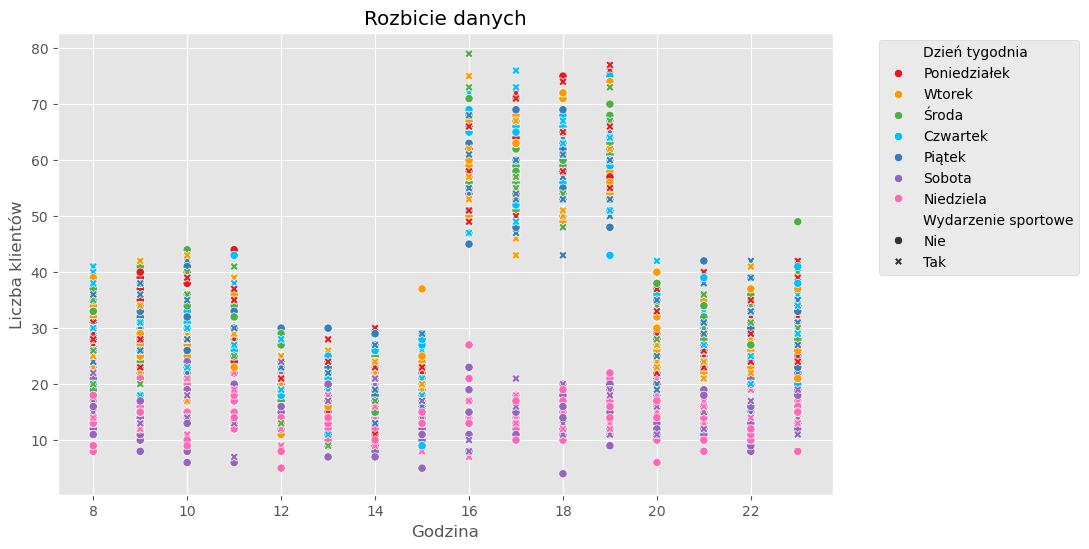

In [4]:
import seaborn as sns

dane2=dane.copy()

etykiety_dni = {
    "Monday": "Poniedziałek",
    "Tuesday": "Wtorek",
    "Wednesday": "Środa",
    "Thursday": "Czwartek",
    "Friday": "Piątek",
    "Saturday": "Sobota",
    "Sunday": "Niedziela"
}

dane2.columns = ["hour","Dzień tygodnia","Wydarzenie sportowe","no.klients"]
dane2["Dzień tygodnia"] = dane2["Dzień tygodnia"].map(etykiety_dni)
dane2["Wydarzenie sportowe"] = dane2["Wydarzenie sportowe"].replace(0,"Nie")
dane2["Wydarzenie sportowe"] = dane2["Wydarzenie sportowe"].replace(1,"Tak")


plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(
    data=dane2,
    x="hour",
    y="no.klients",
    hue="Dzień tygodnia",  
    style="Wydarzenie sportowe",   
    palette=["#E41A1C", "#FF9900", "#4DAF4A", "#00BFFF", "#377EB8", "#9467BD", "#FF69B4"]
)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlabel("Godzina")
plt.ylabel("Liczba klientów")
plt.title("Rozbicie danych")

plt.show()


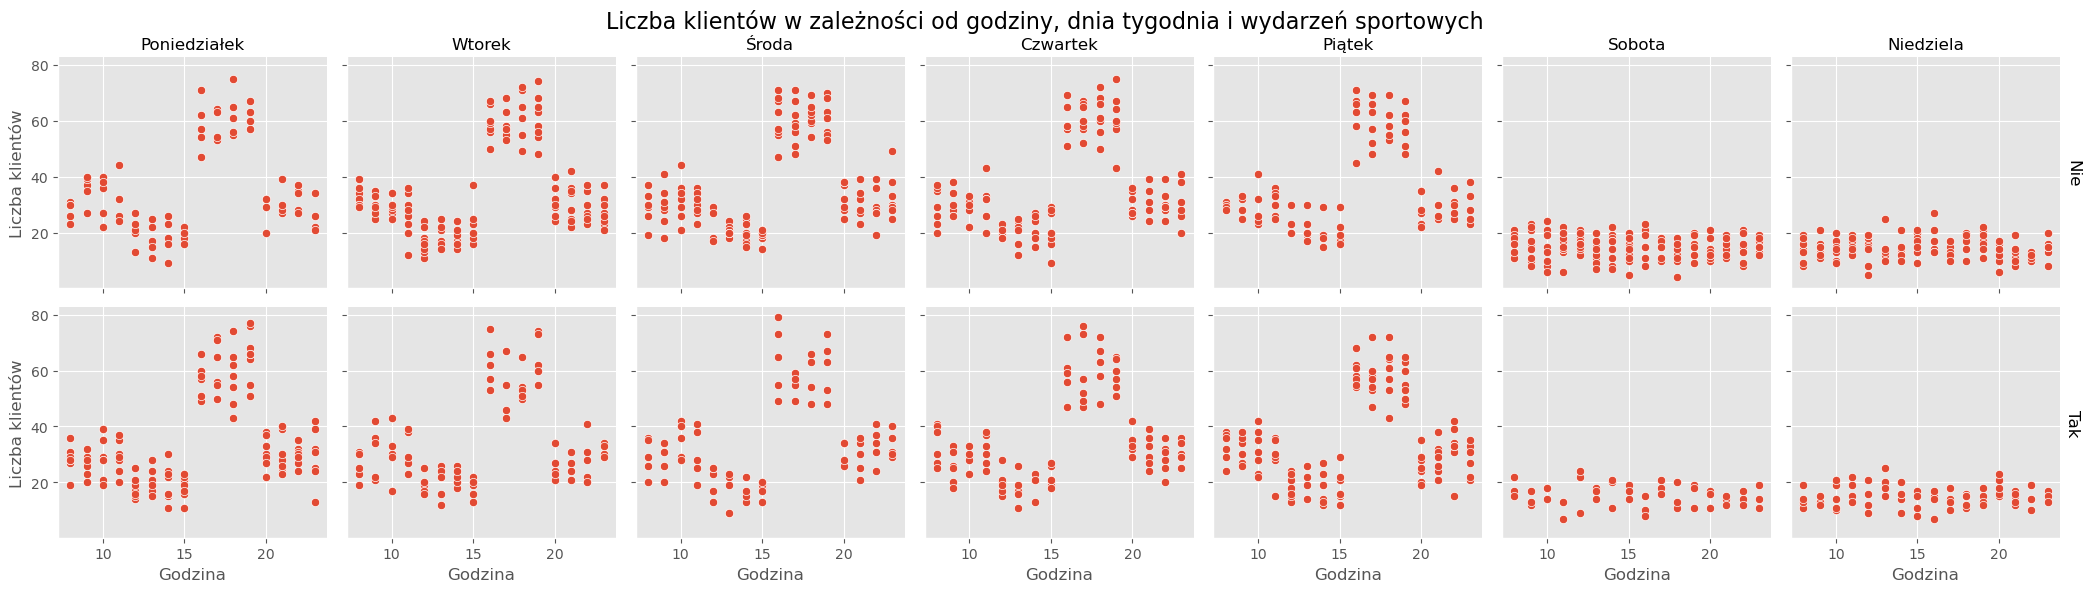

In [5]:
g = sns.FacetGrid(dane2, col="Dzień tygodnia", row="Wydarzenie sportowe", margin_titles=True)
g.map_dataframe(sns.scatterplot, x="hour", y="no.klients")

g.set_axis_labels("Godzina", "Liczba klientów")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

plt.subplots_adjust(top=0.9) 
g.figure.suptitle("Liczba klientów w zależności od godziny, dnia tygodnia i wydarzeń sportowych", fontsize=16)

plt.show()


## Obserwacje i wnioski

- **Wpływ poszczególnych zmiennych**

     - **Dzień tygodnia**
       
       Z wykresów wynika, że dni tygodnia mają duży wpływ na liczbę klientów.<br>
       Największy ruch występuje w środy.<br>
       W weekendy liczba klientów jest znacznie niższa, a rozkład bardziej jednostajny. <br>
       
    - **Godzina**

      Podobnie obserwujemy, że godzina istotnie wpływa na ilość klientów w danym dniu ( poza dniami weekendowmi ). <br>
      Widoczne są wyraźne godziny szczytu (16 - 19) oraz takie, w których liczba ta wyraźnie spada.<br>
      Ponadto wyróżniają się pewne grupy godzin, w których liczba klientów jest zbliżona. ( 4 wyraźnie bloki )<br>
      
  - **Wydarzenia sportowe**

    Na obu wykresach nie widać wyraźnych różnic między dniami z wydarzeniami sportowymi a tymi bez nich.
    W drugim wykresie, który rozdziela dane na podgrupy, liczba klientów w obu przypadkach wygląda podobnie.
    Oznacza to, że zmienna `wydarzenie sportowe` prawdopodobnie nie ma istotnego wpływu na liczbę klientów – inne czynniki, jak dzień tygodnia i godzina, są znacznie silniejsze.
    


>## Rozbicia bez wydarzeń sportowych

W kolejnym kroku sporządzimy te same wykresy, jednak tym razem nie uwzględnimy wpływu zmiennej `wydarzenia sportowe`.

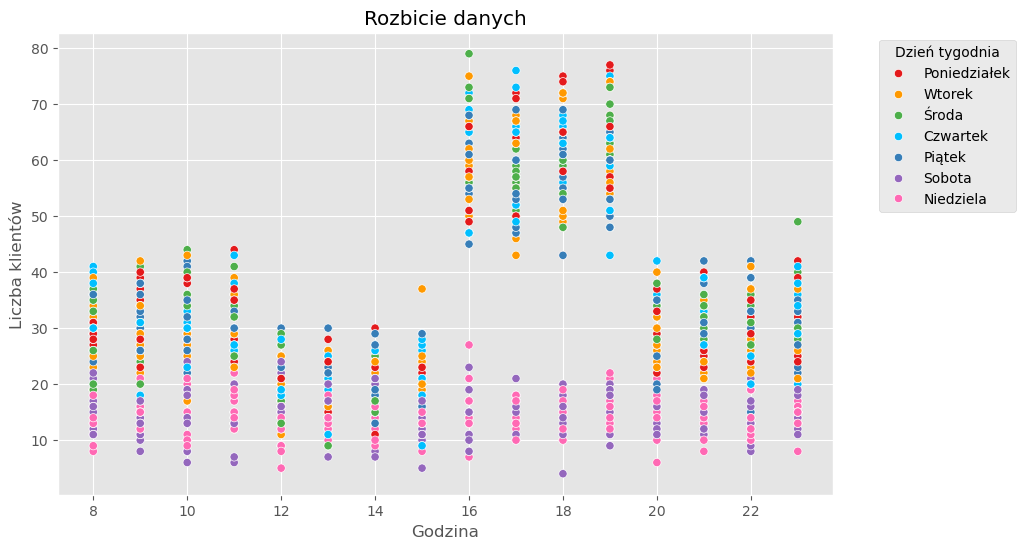

In [6]:

plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(
    data=dane2,
    x="hour",
    y="no.klients",
    hue="Dzień tygodnia",   
    palette=["#E41A1C", "#FF9900", "#4DAF4A", "#00BFFF", "#377EB8", "#9467BD", "#FF69B4"]
)

plt.legend(title="Dzień tygodnia",bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlabel("Godzina")
plt.ylabel("Liczba klientów")
plt.title("Rozbicie danych")

plt.show()


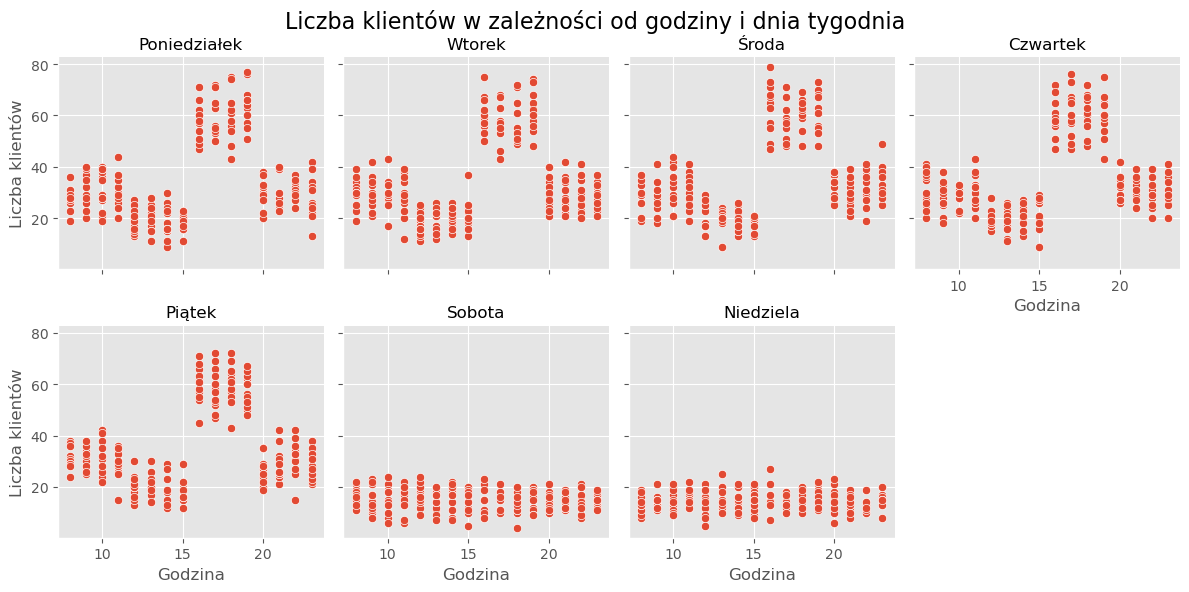

In [7]:
g = sns.FacetGrid(dane2, col="Dzień tygodnia", col_wrap=4, margin_titles=True)
g.map_dataframe(sns.scatterplot, x="hour", y="no.klients")

g.set_axis_labels("Godzina", "Liczba klientów")
g.set_titles(col_template="{col_name}")

plt.subplots_adjust(top=0.9)
g.figure.suptitle("Liczba klientów w zależności od godziny i dnia tygodnia", fontsize=16)

plt.show()


## Obserwacje i wnioski

Podobnie jak wcześniej możemy zauważyć, że częstotliwość klientów różni się w zależności od dnia.<br>
Najwięcej klientów zdaje się przychodzić w środku tygodnia a najmniej w weekendy.<br>
Ponadto obserwujemy, że w weekendy rozkład danych wydaje się być jednostajny, a w pozostałe zróżnicowany. <br>
Z tego względu moglibyśmy pogrupować dane na "Dni robocze" oraz "weekendowe". <br>

Natomiast jak już wspomnieliśmy, częstotliwość klientów w konkretnych godzinach można podzielić na 4 bloki. <br>
Przy czym bloki te zgadzają się z zaobserwowanymi wcześniej ( zwłaszcza przy analizie boxplotów ) własnościami zmiennej. <br>
Godziny 16 - 19 wyróżniają się największą ilością klientów - są one szczytowe. <br>
Najmniej klientów przychodzi w godzinach 12 - 15. <br>
  

# Konstrukcja modeli

Po wnioskach wyciągniętych podczas wstępnej analizy, zajmiejmy się konstrukcją trzech modeli.<br>
Pierwsze dwa modele odpowiednio z/bez zmiennej `wydarzenia sportowe` będą zawierały interakcję pomiędzy wszystkimi regresorami.<br>
Natomiast trzeci model zbudujemy bez interkacji.<br>

> #### Model 1

``` python 
model_poisson = smf.glm(formula="klienci ~C(hour) * C(day) * C(events)", data=dane, family=sm.families.Poisson()).fit()
```
<br>

W tym modelu mamy aż **224** zmiennych objaśniających.

> #### Model 2

``` python 
model_poisson_reduced = smf.glm(formula="klienci ~ C(hour) * C(day)", data=dane, family=sm.families.Poisson()).fit()
```
<br>

W tym modelu bez uwzględnienia zmiennej `wydarzenia sportowe` mamy już tylko **112** zmienne, co świadczy o tym, że dokładnie połowa zależy od tego regresora. <br>

> #### Model 3

``` python 
model_poisson_reduced = smf.glm(formula="klienci ~ C(hour) * C(day)", data=dane, family=sm.families.Poisson()).fit()
```
<br>

W tym przypadku mamy już tylko **9** zmiennych objaśniających.

# Testy

Mamy już przygotowane niezbędne modele. Zatem teraz możemy skonstruować odpowiednie testy i skupić się na odpowiedzeniu na dwa ważne pytania.

In [8]:
dane.columns = ['hour', 'day', 'events', 'klienci']
from sklearn.preprocessing import LabelEncoder

dane["day"]= dane["day"].astype('object')
encoder = LabelEncoder()
for col in dane.select_dtypes(include='object').columns:
    dane[col] = encoder.fit_transform(dane[col])  
dane['day'] = dane['day'].astype('category')
dane['events'] = dane['events'].astype('category')


In [9]:
# Model z interakcjami
model_poisson = smf.glm(formula="klienci ~C(hour) * C(day) * C(events)", data=dane, family=sm.families.Poisson()).fit()
wsp1 = len(model_poisson.params)

In [10]:
# bez wydarzeń sportowych - z interakcjami
model_poisson_reduced = smf.glm(formula="klienci ~ C(hour) * C(day)", data=dane, family=sm.families.Poisson()).fit()
wsp2 = len(model_poisson_reduced.params) # 112
D1 = model_poisson.deviance
D2 = model_poisson_reduced.deviance

In [11]:
model2 = smf.glm(formula="klienci ~ hour + day + events", data=dane, family=sm.families.Poisson()).fit()
wsp3 = len(model2.params)

In [12]:
D3 = model2.deviance
D = D3 - D1
p = 1 - chi2.cdf(D,112).item()

>### 1. Czy zmienna wydarzenia sportowe jest istotna?

Załóżmy poziom istotności $\alpha=0.05$,  mamy do przetestowania hipotezę: 

$$H_0:\ \  \text{Zmienna  wydarzenia sportowe nie jest istotna} \ \ \ vs\ \ \ H_1: \text{Zmienna wydarzenia sportowe jest istotna}.$$

$$\text{statystyka testowa}:$$
$$\chi^2 = D(M_2) - D(M_1) = 1475.73 - 1359.60 = 116.13 $$

$$\text{stopnie swobody}:$$
$$df = 112$$

$$\text{p - wartość}:$$
$$p = 1 - F_{\chi^2}(116.13,112) \approx 0.375 $$

$$
\text{Wniosek: Na poziomie istotności } \alpha = 0.05 \text{ nie możemy odrzucić } H_0
$$

$
\text{Odpowiedź: Wysoka p-wartość sugeruje, że zmienna prawdopodobnie nie jest istotna, lecz nie możemy tego stwierdzić z pełną pewnością.}
$

>### 2. Czy interakcje są istotne?

$$H_0:\ \  \text{Interakcje nie są istotne} \ \ \ vs\ \ \ H_1: \text{Interakcje są istotne}.$$

$$\text{statystyka testowa}:$$
$$\chi^2 = D(M_3) - D(M_1) = 7250.75 - 1359.60 = 5891.15 $$

$$\text{stopnie swobody}:$$
$$df = 215$$

$$\text{p - wartość}:$$
$$p = 1 - F_{\chi^2}(5891.15,215) \approx 0 $$

$$
\text{Wniosek: Odrzucamy } H_0
$$

$
\text{ Odpowiedź: Interakcje są istotne}
$

# Nowe zmienne

Podczas analizy wykresów zauważyliśmy, że oryginalne dane możemy nieco zmodyfikować. <br>
Mianowicie zamiast rozpatrywać każdy dzień tygodnia oraz każdą godzinę w ciągu dnia, możemy uprościć nieco model. <br>

Podzielimy dni na tylko dwie kategorie :

- **Dzień roboczy:** poniedziałek, wtorek,...,piątek
- **Dzień weekendowy:** sobota, niedziela

Natomiast godziny na 4 bloki:

- **I:** 8:00 - 11:59
- **II:** 12:00 - 15:59
- **III:** 16:00 - 19:59
- **IV:** 20:00 - 23:59


>### Konstrukcja modelu

Po klasyfikacji danych według wyżej wymienionych grup , możemy stworzyć nowy model z interakcjami pomiędzy tymi *nowymi zmiennymi*.


>> #### Model 4

```python
 model_new = smf.glm(formula="klienci ~ C(kategoria_dnia) * C(Blok)", data=dane2, family=sm.families.Poisson()).fit()
```
>>Tak skonstuowany model ma już tylko **8** zmiennych objaśniających, co upraszcza go znacząco. <br>

In [13]:
dane2["kategoria_dnia"]=dane2["Dzień tygodnia"].isin(["Sobota","Niedziela"])
dane2["kategoria_dnia"] = dane2["kategoria_dnia"].map({False: "Dzień roboczy", True: "Weekend"})
dane2["Blok"] = pd.cut(dane2["hour"], bins=[8, 12, 16, 20, 24], labels=["I", "II", "III", "IV"], right=False)

In [14]:
dane2["kategoria_dnia"] = dane2["kategoria_dnia"].astype("category")

In [15]:
dane2.columns = ["hour","Dzień tygodnia","Wydarzenie sportowe","klienci","kategoria_dnia","Blok"]

In [16]:
# Model z interakcją tych dwóch nowych zmiennych
model_new = smf.glm(formula="klienci ~ C(kategoria_dnia) * C(Blok)", data=dane2, family=sm.families.Poisson()).fit()
wsp4 = len(model_new.params) # 8`

In [17]:
D4 = model_new.deviance

In [18]:
D = D4 - D1
p = 1 - chi2.cdf(D,216).item()

>### Test 1

Warto teraz sprawdzić, czy nowy model różni się statystycznie od pierwotnego. W tym celu przetestujmy poniższą hipotezę:

$$H_0:\ \  \text{Model 4 nie różni się od Modelu 1 } \ \ \ vs\ \ \ H_1: \text{Model 4 różni się od Modelu 1}.$$

$$\text{statystyka testowa}:$$
$$\chi^2 = D(M_4) - D(M_1) = 1552.45 - 1359.60   = 192.85 $$

$$\text{stopnie swobody}:$$
$$df = 216$$

$$\text{p - wartość}:$$
$$p = 1 - F_{\chi^2}(192.85,216) \approx 0.87 $$



$\text{Wniosek: Na poziomie istotności } \alpha = 0.05 \text{ nie mamy podstaw do odrzucenia } H_0.$
$\text{ Natomiast wysoka wartość p-wartości sugeruje, że modele nie różnią się istotnie.}$



>## Wizualizacja

Zmniejszona liczba zmiennych objaśnianych w modelu pozwala nam dokładniej przyjrzeć się teoretycznym wartościom ( dla 224 zmiennych nie byłoby to możliwe ). <br>
Przedstawmy je zatem w poniższych tabelkach.

In [19]:
# Tworzymy tabelke
dni_robocze = pd.DataFrame({"Godzina":["8:00 - 11:59","12:00 - 15:59","16:00 - 19:59","20:00 - 23:59"]
})

In [20]:
bloki = ["I", "II", "III", "IV"]
srednia_liczba_klientow = [
    dane2[(dane2["Blok"] == blok) & (dane2["kategoria_dnia"] == "Dzień roboczy")]["klienci"].mean().item()
    for blok in bloki
]

In [21]:
dni_robocze["Średnia liczba klientów"] = srednia_liczba_klientow 

In [22]:
betas = [x.item() for x in model_new.params.values]

In [23]:
dni_robocze["Predyktor"]= [r"$\beta_0$",r"$\beta_0 + \beta_2$",r"$\beta_0 + \beta_3$",r"$\beta_0 + \beta_4$"]
dni_robocze["Wartość"] = [betas[0],betas[0]+betas[2],betas[0]+betas[3], betas[0]+betas[4]]

In [24]:
dni_robocze = dni_robocze.round(2).T

In [25]:
dni_robocze.style.format(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x) \
    .set_table_styles([
        {'selector': 'td, th', 'props': [('border', '1px solid black')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', 'lightgray')]}, 
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', 'white')]},
        {'selector': 'caption', 'props': [('font-weight', 'bold')]},
    ]) \
    .hide(axis="columns").set_table_attributes("style='margin:auto; font-size:16px'").set_caption("Dzień roboczy")

Godzina,8:00 - 11:59,12:00 - 15:59,16:00 - 19:59,20:00 - 23:59
Średnia liczba klientów,30.010,19.710,59.640,29.980
Predyktor,$\beta_0$,$\beta_0 + \beta_2$,$\beta_0 + \beta_3$,$\beta_0 + \beta_4$
Wartość,3.400,2.980,4.090,3.400


In [26]:
# Tworzymy tabelke
dni_weekendowe = pd.DataFrame({"Godzina":["8:00 - 11:59","12:00 - 15:59","16:00 - 19:59","20:00 - 23:59"]
})

srednia_liczba_klientow1 = [
    dane2[(dane2["Blok"] == blok) & (dane2["kategoria_dnia"] == "Weekend")]["klienci"].mean().item()
    for blok in bloki
]

dni_weekendowe["Średnia liczba klientów"] = srednia_liczba_klientow1

dni_weekendowe["Predyktor"]= [r"β_0 + β_1","β_0 + β_1 + β_2 + β_5","β_0 + β_1 + β_3 + β_6","β_0 + β_1 + β_4 + β_7"]
dni_weekendowe["Wartość"] = [betas[0] + betas[1] ,betas[0]+ betas[1] +betas[2]+betas[5],betas[0] + betas[1] + betas[6]+betas[3], betas[0]+betas[1]+betas[4]+betas[7]]


In [27]:
dni_weekendowe = dni_weekendowe.round(2).T

In [28]:
dni_weekendowe.style \
    .format(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x) \
    .hide(axis="columns") \
    .set_table_styles([
        {'selector': 'td, th', 'props': [('border', '1px solid black')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', 'lightgray')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', 'white')]},
        {'selector': 'caption', 'props': [('font-weight', 'bold')]},
    ])  \
    .set_table_attributes("style='margin:auto; font-size:16px'") \
    .set_caption("Dzień weekendowy")


Godzina,8:00 - 11:59,12:00 - 15:59,16:00 - 19:59,20:00 - 23:59
Średnia liczba klientów,14.79,14.95,14.87,14.38
Predyktor,β_0 + β_1,β_0 + β_1 + β_2 + β_5,β_0 + β_1 + β_3 + β_6,β_0 + β_1 + β_4 + β_7
Wartość,2.69,2.70,2.70,2.67


Dzięki temu możemy zobaczyć, że nasze wcześniejsze obserwacje były słuszne.<br>
W ciągu dni powszednich średnia liczba klientów w zależności od godziny jest zróżnicowana, podobnie jak wartości predyktorów liniowych. <br>

Natomiast w dni weekendowe średnia liczba klientów oraz wartości predyktorów liniowych są niemalże identyczne niezależnie od godziny. <br>

>### Test 2

Obserwacje te dają nam motywacje, aby sprawdzić, czy predyktory liniowe dla dni weekendowych w rzeczywistości są równe.<br>
W tym celu posłużymy się *testem Walda*. <br>

In [29]:
predyktory = list(dni_weekendowe.loc["Wartość"])

In [30]:
R = np.array([
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 0, 1]  
])

wald_test = model_new.wald_test(R, scalar=False)
statystyka_walda = wald_test.statistic[0][0].round(2).item()  # Statystyka testowa chi-kwadrat
p_wartosc = wald_test.pvalue.round(2).item()  # p-wartość
df = int(wald_test.df_denom)

Niech:

$\eta_5 = \beta_0 + \beta_1,$\
$\eta_6 = \beta_0 + \beta_1 + \beta_2 + \beta_5,$ \
$\eta_7 = \beta_0 + \beta_1 + \beta_3 + \beta_6,$ \
$\eta_8 = \beta_0 + \beta_1 + \beta_4 + \beta_7.$

Przetestujmy następującą hipotezę:

$$H_0:\ \eta_5 = \eta_6 = \eta_7 = \eta_8\ \ \ \text{przeciwko}\ \ \ H_1:\ (\exists i \neq j)\ \eta_i \neq \eta_j.$$

$$\text{statystyka testowa}:$$
$$W = 1.38 $$

$$\text{stopnie swobody}:$$
$$df = 3$$

$$\text{p - wartość}:$$
$$p \approx 0.71 $$

$\text{Wniosek: Na poziomie istotności } \alpha = 0.05 \text{ nie mamy podstaw do odrzucenia } H_0.$

$\text{ Jednak wysoka p-wartość sugeruje silną zgodność danych z hipotezą zerową.}$

>## Grafik

Ostatnim czym się zajmiemy jest ustalenie optymalnej liczby pracowników w analizowanym przez nas sklepie oraz skonstruowanie dla nich grafiku.

- Zakładamy, że 1 pracownik w ciągu godziny może obsłużyć maksymalnie 20 klientów.
- Każdy pracownik pracuje po 8h.
- Nikt nie przekracza 40h tygodniowo.

Propozycja graifku prezentuje się następująco:

In [31]:

dni_tygodnia = ["Poniedziałek", "Wtorek", "Środa", "Czwartek", "Piątek", "Sobota", "Niedziela"]

grafik_dict = {
    "Pracownik 1": ["8:00 - 16:00"] * 5 + ["-", "-"],
    "Pracownik 2": ["8:00 - 16:00"] * 5 + ["-", "-"],
    "Pracownik 3": ["16:00 - 24:00"] * 5 + ["-", "-"],
    "Pracownik 4": ["16:00 - 24:00"] * 5 + ["-", "-"],
    "Pracownik 5": ["16:00 - 24:00"] * 5 + ["-", "-"],
    "Pracownik 6": ["-", "-"] + ["8:00 - 16:00"] * 3 + ["8:00 - 16:00", "8:00 - 16:00"],
    "Pracownik 7": ["-", "-"] + ["16:00 - 24:00"] * 3 + ["16:00 - 24:00","16:00 - 24:00"],
}

grafik_df = pd.DataFrame.from_dict(grafik_dict, orient='index', columns=dni_tygodnia)

grafik_df.style.set_table_styles([
        {'selector': 'td, th', 'props': [('border', '1px solid black')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', 'lightgray')]},
        {'selector': 'tr:nth-child(odd)', 'props': [('background-color', 'white')]},
        {'selector': 'caption', 'props': [('font-weight', 'bold')]},
    ])  \
    .set_table_attributes("style='margin:auto; font-size:16px'") \
    .set_caption("Grafik pracy")


,Poniedziałek,Wtorek,Środa,Czwartek,Piątek,Sobota,Niedziela
Pracownik 1,8:00 - 16:00,8:00 - 16:00,8:00 - 16:00,8:00 - 16:00,8:00 - 16:00,-,-
Pracownik 2,8:00 - 16:00,8:00 - 16:00,8:00 - 16:00,8:00 - 16:00,8:00 - 16:00,-,-
Pracownik 3,16:00 - 24:00,16:00 - 24:00,16:00 - 24:00,16:00 - 24:00,16:00 - 24:00,-,-
Pracownik 4,16:00 - 24:00,16:00 - 24:00,16:00 - 24:00,16:00 - 24:00,16:00 - 24:00,-,-
Pracownik 5,16:00 - 24:00,16:00 - 24:00,16:00 - 24:00,16:00 - 24:00,16:00 - 24:00,-,-
Pracownik 6,-,-,8:00 - 16:00,8:00 - 16:00,8:00 - 16:00,8:00 - 16:00,8:00 - 16:00
Pracownik 7,-,-,16:00 - 24:00,16:00 - 24:00,16:00 - 24:00,16:00 - 24:00,16:00 - 24:00


## Podsumowanie i wnioski

Analiza wykazała różnice w liczbie klientów między dniami roboczymi a weekendami, jednak w obrębie tych grup wartości są do siebie zbliżone.<br>
Ponadto, obecność wydarzenia sportowego nie ma istotnego wpływu na liczbę klientów.<br>

W związku z tym warto uprościć model, łącząc dni i godziny w szersze kategorie oraz rezygnując z podziału na dni z i bez wydarzeń sportowych.<br>
Dzięki temu model stanie się bardziej przejrzysty i efektywny.

In [32]:
# Jak generować bez kodu i bez ostrzeżeń
!jupyter nbconvert --to html --no-input --log-level=ERROR Lista2-ZML.ipynb